# Curtiss and Hirschfelder problem

We would like to solve the folowing problem:

$$
    \begin{cases}
        \dot{y} = k(\cos(t) - y)\\
        y(0)  = y_0
    \end{cases}
$$

with $k>1$, a parameter that allows to control the stiffness of the problem.

In [1]:
%system mkdir -p curtiss

[]

In [2]:
%%writefile curtiss/main.cpp

#include <iostream>
#include <valarray>

#include "solver/solver.hpp"
#include "solver/observer.hpp"
#include "solver/problem.hpp"
#include "solver/butcher_methods.hpp"

int main()
{
    using namespace observer;

    double k = 50.0;
    
    double L = -k;
    auto N = [=]( double t, double const& u )
    {
        return k*std::cos(t);
    };
    auto pb  = ode::make_lawson_problem(L, N);

    double dt = 0.05;
    double tf = 2.0;
    double y_ini = 2.0;
    
    auto exp = [](double x){ return std::exp(x); };
    
    ode::solve(pb, ode::butcher::rk_44(), y_ini, {0.,tf}, dt, "curtiss/sol_rk44.dat"_fobs);
    ode::solve(pb, ode::butcher::lrk_44(exp), y_ini, {0.,tf}, dt, "curtiss/sol_lrk44.dat"_fobs);
    
    ode::solve(pb, ode::butcher::hochbruck_ostermann(), y_ini, {0.,tf}, dt, "curtiss/sol_ho.dat"_fobs);
    ode::solve(pb, ode::butcher::exprk22(), y_ini, {0.,tf}, dt, "curtiss/sol_exprk22.dat"_fobs);
    
    auto jacobian = [=]( double t, double const& u )
    {
        return -k;
    };
    auto ipb = ode::make_implicit_problem(pb, jacobian);
    ode::solve(ipb, ode::butcher::lsdirk43(), y_ini, {0.,tf}, dt, "curtiss/sol_dirk.dat"_fobs);
    
    return 0;
}

Overwriting curtiss/main.cpp


In [3]:
%system $CXX -std=c++20 -I ../include -I $CONDA_PREFIX/include curtiss/main.cpp -o curtiss/main

[]

In [4]:
%system ./curtiss/main

[]

In [5]:
import numpy as np
import matplotlib.pyplot as plt

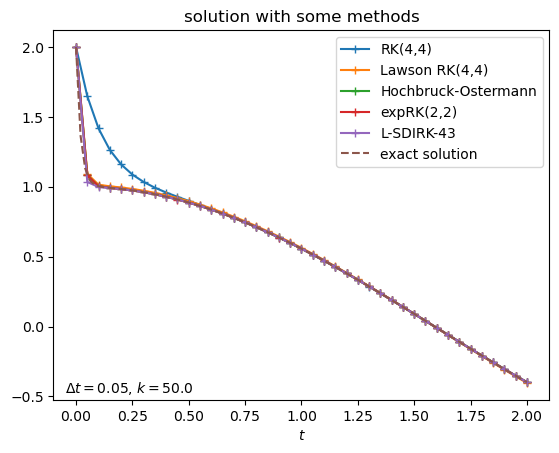

In [6]:
methods = {
    'rk44': "RK(4,4)",
    'lrk44': "Lawson RK(4,4)",
    'ho': "Hochbruck-Ostermann",
    'exprk22': "expRK(2,2)",
    'dirk': "L-SDIRK-43"
}

for key, val in methods.items():
    data = np.loadtxt(f"curtiss/sol_{key}.dat")
    t = data[:, 0]
    y = data[:, 1]
    
    plt.plot(t, y, "+-", label=val)

# keep some parameters from last methods
y0 = y[0]
t0 = t[0]
tf = t[-1]
k = 50.0

def sol(t):
    c0 = (y0 - k/(k**2+1)*( k*np.cos(t0) + np.sin(t0) ))*np.exp(-k*t0)
    return k/(k**2+1)*(k*np.cos(t) + np.sin(t)) + c0*np.exp(-k*t)

time = np.linspace(t0, tf, int(tf-t0)*50)
exact_sol = sol(time)

plt.plot(time, exact_sol, "--", label="exact solution")

plt.xlabel("$t$")
plt.title("solution with some methods")
plt.text(plt.xlim()[0] + 0.05,plt.ylim()[0] + 0.05, r"$\Delta t = {}$, $k={}$".format(data[0,-1], k))
plt.legend()
plt.show()

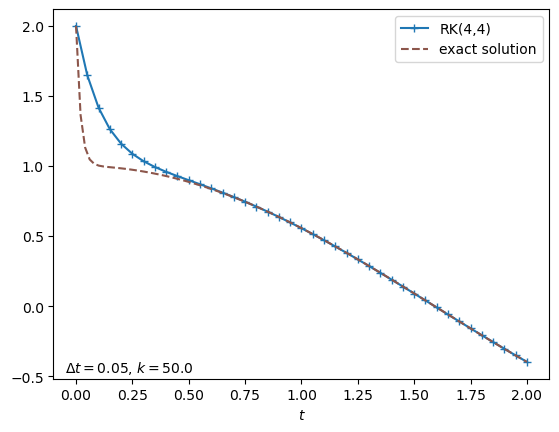

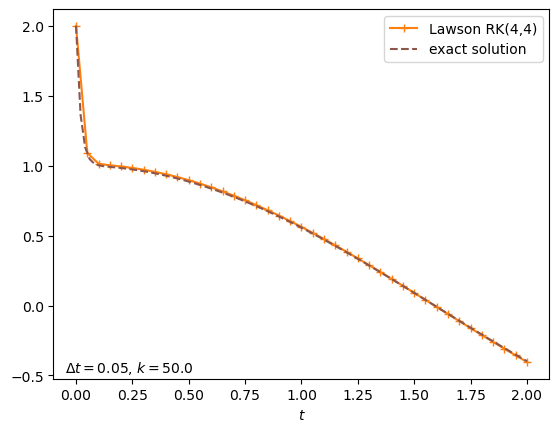

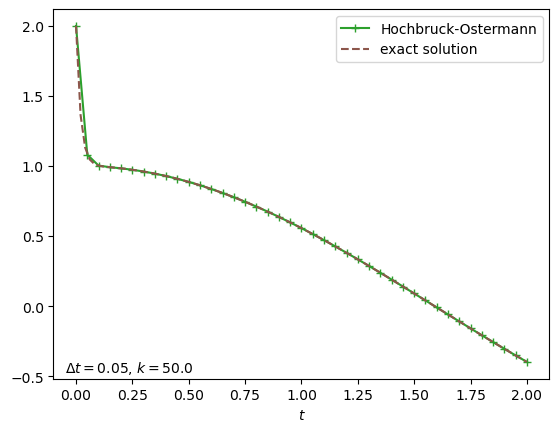

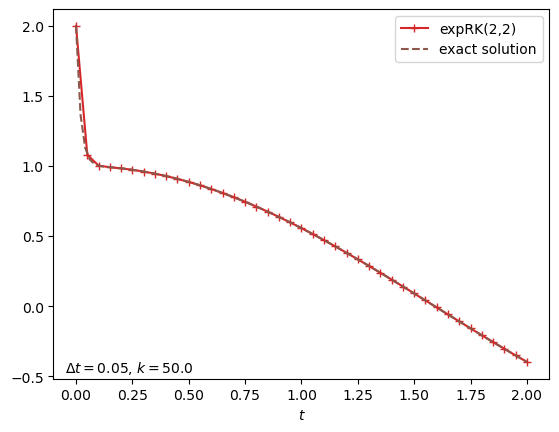

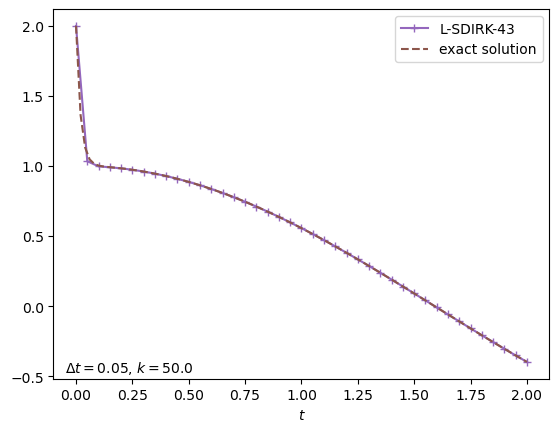

In [7]:
for i, (key, val) in enumerate(methods.items()):
    data = np.loadtxt(f"curtiss/sol_{key}.dat")
    t = data[:, 0]
    y = data[:, 1]
    
    plt.plot(t, y, "+-", color=f"C{i}", label=val)
    plt.plot(time, exact_sol, "--", color="C5", label="exact solution")
    
    plt.xlabel("$t$")
    plt.text(plt.xlim()[0] + 0.05,plt.ylim()[0] + 0.05, r"$\Delta t = {}$, $k={}$".format(data[0,-1], k))
    plt.legend()
    plt.show()
    

In [8]:
def error( t, y ):
    return np.abs( (sol(t) - y) )
def relative_error( t, y ):
    return np.abs( (sol(t) - y)/sol(t) )

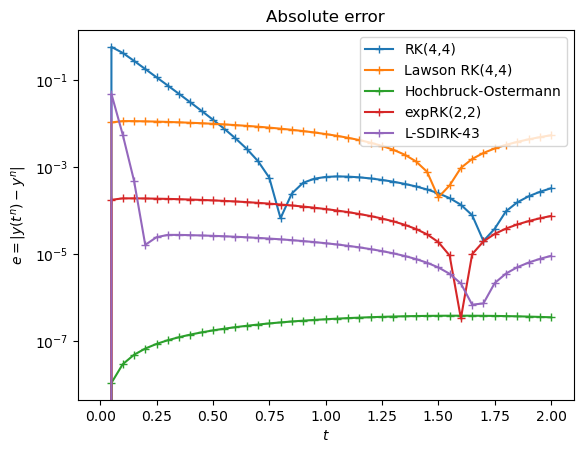

In [9]:
for key, val in methods.items():
    data = np.loadtxt(f"curtiss/sol_{key}.dat")
    t = data[:, 0]
    y = data[:, 1]
    
    plt.plot(t, error(t, y), "+-", label=val)
    
plt.legend()
plt.xlabel("$t$")
plt.ylabel("$e = | y(t^n) - y^n |$")
plt.yscale('log')
plt.title("Absolute error")
plt.show()

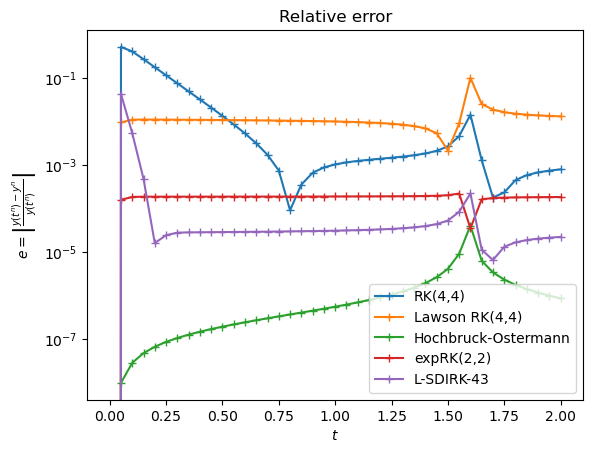

In [10]:
for key, val in methods.items():
    data = np.loadtxt(f"curtiss/sol_{key}.dat")
    t = data[:, 0]
    y = data[:, 1]
    
    plt.plot(t, relative_error(t, y), "+-", label=val)
    
plt.legend()
plt.xlabel("$t$")
plt.ylabel("$e = \\left| \\frac{y(t^n) - y^n}{y(t^n)} \\right|$")
plt.yscale('log')
plt.title("Relative error")
plt.show()